In [1]:
parPercents=[83.8202, 84.1504, 84.4806, 84.8108, 85.1410, 85.4712, 85.8014, 86.1316, 86.4816, 86.7920, 87.1222, 87.4524, 87.7826, 88.1128, 88.4430]
superfluousPercents=list(range(2, 31, 2))
egPercents=[100-par for par in parPercents]
egPercents

[16.1798,
 15.849599999999995,
 15.519400000000005,
 15.1892,
 14.858999999999995,
 14.528800000000004,
 14.198599999999999,
 13.868399999999994,
 13.5184,
 13.207999999999998,
 12.877799999999993,
 12.547600000000003,
 12.217399999999998,
 11.887200000000007,
 11.557000000000002]

In [2]:
(5.5/807.51)/((5.5/807.51)+(31)/914)

0.16723325929205807

In [3]:
nonsuperfluousPar=[par-sup for par, sup in zip(parPercents, superfluousPercents)]
nonsuperfluousEGPer=[egPer/(egPer+nonSupPar) for egPer, nonSupPar in zip(egPercents, nonsuperfluousPar)]

In [4]:
nonsuperfluousEGPer

[0.1651,
 0.16509999999999994,
 0.16510000000000005,
 0.1651,
 0.16509999999999994,
 0.16510000000000005,
 0.1651,
 0.16509999999999994,
 0.16485853658536584,
 0.16509999999999997,
 0.1650999999999999,
 0.16510000000000002,
 0.16509999999999997,
 0.1651000000000001,
 0.16510000000000002]

(15, 15)

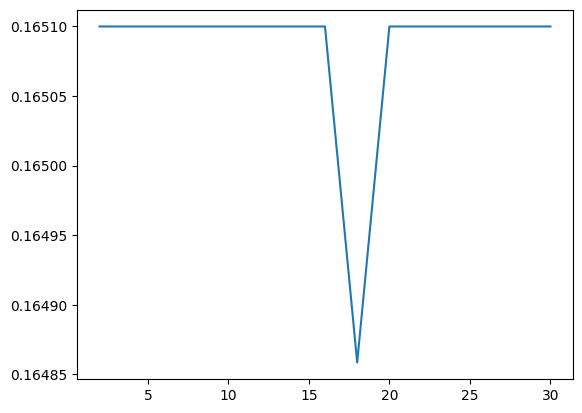

In [5]:
import matplotlib.pyplot as plt
plt.plot(superfluousPercents, nonsuperfluousEGPer)
len(superfluousPercents), len(nonsuperfluousEGPer)

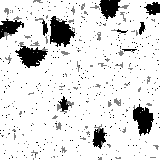

In [13]:
absorptionRate=.1651
import random
import torch
import torchvision as tv
from collections import deque

grid=torch.rand((160, 160))

tensorToImageTransform=tv.transforms.ToPILImage()

def corePhase(grid, prob=0.05):
    return (grid>prob).float()

tensorToImageTransform(grid)

def generateSample3(rows, cols, coreProb, growthProb, wtPercent):
    growthMaterial=(int)(wtPercent>=4)
    vol=0
    totVol=rows*cols
    pDensity=914
    egDensity=269
    egPerSaturatedEG=0.1651
    nonGrowthEndingVol=(wtPercent/egDensity)/(egPerSaturatedEG*(wtPercent/egDensity+(100-wtPercent)/pDensity)) if wtPercent<4 else 1-(wtPercent/egDensity)/(egPerSaturatedEG*(wtPercent/egDensity+(100-wtPercent)/pDensity))
    grid=[[(int)(not growthMaterial)]*cols for i in range(rows)]
    cores=[]
    coreProb=min(nonGrowthEndingVol, coreProb)
    for row in range(rows):
        if vol/totVol>=nonGrowthEndingVol:
            break
        for col in range(cols):
            if random.random()<coreProb:
                grid[row][col]=growthMaterial
                vol+=1
                cores.append([row, col])

    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    iters=0
    prevVol=0

    print(nonGrowthEndingVol, vol, totVol)
    
    while vol/totVol<nonGrowthEndingVol:
        idx=random.randint(0, len(cores)-1)
        [currX, currY]=cores[idx]
        adjNonGrowth=False
        for dir in dirs:
            nx, ny=currX+dir[0], currY+dir[1]
            if nx<0 or nx>=rows or ny<0 or ny>=cols:
                continue
            if grid[nx][ny]!=growthMaterial and random.random()<growthProb:
                grid[nx][ny]=growthMaterial
                cores.append([nx, ny])
                vol+=1
            if grid[nx][ny]!=growthMaterial:
                adjNonGrowth=True
        if not adjNonGrowth:
            cores[idx], cores[-1]=cores[-1], cores[idx]
            cores.pop()
        iters+=1
        if iters%(10000/growthProb)==0:
            print(iters, vol/totVol, vol, totVol, nonGrowthEndingVol, len(cores))
            if prevVol==vol:
                break
            prevVol=vol
    
    return grid

def generateHybridSample(rows, cols, coreProbs, growthProbs, vols):
    numMaterials=len(coreProbs)
    materials=[i/numMaterials for i in range(numMaterials)]
    grid=[[1]*cols for i in range(rows)]
    cores=[[] for i in range(numMaterials)]
    currVols=[0 for i in range(numMaterials)]
    vol=0

    for i in range(numMaterials):
        coreProb=min(vols[i], coreProbs[i])*rows*cols/(rows*cols-vol)
        for row in range(rows):
            for col in range(cols):
                if random.random()<coreProb and grid[row][col]==1:
                    grid[row][col]=materials[i]
                    vol+=1
                    totGrowth=growthProbs[i]*random.uniform(0.2, 0.8)
                    vertGrowth=totGrowth*random.uniform(0.05, 0.95)
                    horGrowth=totGrowth-vertGrowth
                    cores[i].append([row, col, vertGrowth, horGrowth])
                    currVols[i]+=1

    for i in range(numMaterials):
        for _ in range(int(rows*cols*0.01)):  # Adjust sparsity factor
            row, col=random.randint(0, rows-1), random.randint(0, cols-1)
            if grid[row][col]==1:
                grid[row][col]=materials[i]
                currVols[i]+=1

    dirs = [[0,1],[0,-1],[1,1],[1,-1],[1,0],[-1,1],[-1,-1],[-1,0]]
    iters=0
    while any([currVol/(rows*cols)<endVol for currVol, endVol in zip(currVols, vols)]):
        for i in range(numMaterials):
            if currVols[i]/(rows*cols)>=vols[i]:
                continue
            idx=random.randint(0, len(cores[i])-1)
            [currX, currY, vertGrowth, horGrowth]=cores[i][idx]
            adjNonGrowth=False
            for dir in dirs:
                nx, ny=currX+dir[0], currY+dir[1]
                if nx<0 or nx>=rows or ny<0 or ny>=cols:
                    continue
                if dir[0]==0 and grid[nx][ny]==1 and random.random()<vertGrowth:
                    grid[nx][ny]=materials[i]
                    cores[i].append([nx, ny, vertGrowth, horGrowth])
                    currVols[i]+=1
                if dir[1]==0 and grid[nx][ny]==1 and random.random()<horGrowth:
                    grid[nx][ny]=materials[i]
                    cores[i].append([nx, ny, vertGrowth, horGrowth])
                    currVols[i]+=1
                if grid[nx][ny]==1:
                    adjNonGrowth=True
            if not adjNonGrowth:
                cores[i][idx], cores[i][-1]=cores[i][-1], cores[i][idx]
                cores[i].pop()
            
    
    return grid

grid=generateHybridSample(160, 160, [0.0005, 0.005], [0.1, 0.1], [0.10, 0.05])
display(tensorToImageTransform(torch.tensor(grid, dtype=torch.float32)))

In [60]:
import cProfile
# grid=torch.rand((160, 160))
# grid=[[1]*160 for i in range(160)]
grid=generateSample3(160, 160, (random.random()%0.0005)+0.001, 0.05, 4.5)

0.16409111853926706 26 25600


21399


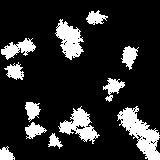

In [61]:
grid_tensor=torch.tensor(grid, dtype=torch.float32)
print(len(torch.nonzero(grid_tensor==0)))
display(tensorToImageTransform(grid_tensor))

In [10]:
#eg true density
egDensity=268.934
parDensity=914
egPerSaturatedEG=0.1651

totVol=160*160
saturatedEgVol=len(torch.nonzero(grid_tensor==0))
superfluousParVol=totVol-saturatedEgVol
parVol=superfluousParVol+(1-egPerSaturatedEG)*saturatedEgVol
egVol=egPerSaturatedEG*saturatedEgVol
egWeight=egVol*egDensity
parWeight=parVol*parDensity
egWeight/(egWeight+parWeight)

0.049987341319302374

In [11]:
saturatedEgDensity=807.51
egDensities=[(saturatedEgDensity-(1-egPerSaturatedEG)*parDensity)/egPerSaturatedEG]
egDensities

[268.99697153240436]

In [12]:
import numpy as np

def lbm_np(grid):
    # setting constants, temperature field, and distribution function
    parRelaxTime=0.558915
    satEGRelaxTime=0.978183

    tHot=293
    tCold=283
    tInitial=(tHot+tCold)/2

    rows=len(grid)
    cols=len(grid[0])
    if type(grid) is list:
        grid=np.array(grid)
    omega=1/4

    directions=np.array([[1,0],[0,1],[-1,0],[0,-1]])
    T=np.full((rows, cols), tInitial)
    distributionFunction=np.zeros((4, rows, cols))

    # helper functions
    def applyBoundaryConditions(T, distributionFunction):
        T[:,0]=tHot
        T[:,-1]=tCold
        
        # eq=equilibriumDistribution(T)
        distributionFunction[:,:,0]=omega*T[:,0]
        # distributionFunction[3,:,0]+=distributionFunction[3,:,1]-eq[:,1]
        distributionFunction[:,:,-1]=omega*T[:,-1]
        # distributionFunction[1,:,-1]+=distributionFunction[1,:,-2]-eq[:,-2]

    def equilibriumDistribution(T):
        return T*omega
    
    def calculateTemperature(distributionFunction):
        return np.sum(distributionFunction, axis=0)
    
    def collisionStep(distributionFunction, relaxMap):
        eq=equilibriumDistribution(calculateTemperature(distributionFunction))
        for dir in range(4):
            distributionFunction[dir]-=(distributionFunction[dir]-eq)/relaxMap

    def streamingStep(distributionFunction):
        for dir, [x, y] in enumerate(directions):
            distributionFunction[dir]=np.roll(np.roll(distributionFunction[dir], x, axis=0), y, axis=1)

    def calculateThermalConductivity(distributionFunction):
        deltaT=tHot-tCold
        qFlux=(np.sum(distributionFunction[1,:,:])-np.sum(distributionFunction[3,:,:]))*(np.mean(relaxMap)-0.5)/np.mean(relaxMap)
        return 1000*qFlux/(deltaT*rows*cols)

    # setting up initial conditions
    numSteps=100000
    tolerance=1e-9
    relaxMap=np.where(grid==1, parRelaxTime, satEGRelaxTime)
    # display(tensorToImageTransform(relaxMap))
    # display(tensorToImageTransform((T-tCold)/(tHot-tCold)))
    for dir in range(4):
        distributionFunction[dir,:,:]=equilibriumDistribution(T)
    applyBoundaryConditions(T, distributionFunction)
    
    for step in range(numSteps):
        T_old=T.copy()
        for dir in range(4):
            distributionFunction[dir]-=(distributionFunction[dir]-T*omega)/relaxMap
        streamingStep(distributionFunction)
        applyBoundaryConditions(T, distributionFunction)
        T=calculateTemperature(distributionFunction)

        error=np.sqrt(np.sum(np.square((T-T_old)))/np.sum(np.square(T)))
        if error<tolerance:
            print("CONVERGED ON STEP", step, "WITH ERROR", error)
            break
        # if step%1000==0:
        #     print('TC', calculateThermalConductivity(distributionFunction))
        #     print('RIGHT FLUX', np.sum(distributionFunction[1,:,:]))
        #     print('LEFT FLUX', np.sum(distributionFunction[3,:,:]))
        #     print('EG RIGHT FLUX', np.sum(np.where(grid==0, distributionFunction[1,:,:], 0)))
        #     print('EG LEFT FLUX', np.sum(np.where(grid==0, distributionFunction[3,:,:], 0)))
        #     print('PAR RIGHT FLUX', np.sum(np.where(grid==1, distributionFunction[1,:,:], 0)))
        #     print('PAR LEFT FLUX', np.sum(np.where(grid==1, distributionFunction[3,:,:], 0)))
        #     display(tensorToImageTransform((T-tCold)/(tHot-tCold)))
    return T, calculateThermalConductivity(distributionFunction)
tHot=293
tCold=283
grid1=[[1 for c in range(160)] for r in range(160)]
temps, cond=lbm_np(grid1)

KeyboardInterrupt: 

In [ ]:
test1=np.zeros((4,2,4))
test2=np.array([1,2,3,4])
test1[:,0,:]+=test2
test1

array([[[1., 2., 3., 4.],
        [0., 0., 0., 0.]],

       [[1., 2., 3., 4.],
        [0., 0., 0., 0.]],

       [[1., 2., 3., 4.],
        [0., 0., 0., 0.]],

       [[1., 2., 3., 4.],
        [0., 0., 0., 0.]]])

In [ ]:
rows, cols=4, 4
T=np.full((rows, cols), (tHot+tCold)/2)
tauMap=np.full((rows, cols), 0.5)
T[:,0]=tHot
T[:,-1]=tCold
omega=1/4
distF=np.zeros((4, rows, cols))
distF[:,:,:]=T[:,:]*omega
distF

array([[[73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75]],

       [[73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75]],

       [[73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75]],

       [[73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75]]])

In [ ]:
distF[:,0,1:-1]+=distF[2,0,1:-1]/3
distF[2,0,1:-1]=0
distF[:,-1,1:-1]+=distF[0,-1,1:-1]/3
distF[0,-1,1:-1]=0
distF

array([[[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25,  0.  ,  0.  , 70.75]],

       [[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]],

       [[73.25,  0.  ,  0.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]],

       [[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]]])

In [ ]:
for dir in range(4):
    distF[dir,1:-1,:]-=(distF[dir,1:-1,:]-T[1:-1,:]*omega)/tauMap[1:-1,:]
distF

array([[[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25,  0.  ,  0.  , 70.75]],

       [[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]],

       [[73.25,  0.  ,  0.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]],

       [[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]]])

In [ ]:
for dir in range(4):
    if dir!=2:
        distF[dir,0,1:-1]-=(distF[dir,0,1:-1]-T[0,1:-1]/3)/tauMap[0,1:-1]
    if dir!=0:
        distF[dir,-1,1:-1]-=(distF[dir,-1,1:-1]-T[-1,1:-1]/3)/tauMap[-1,1:-1]
distF

array([[[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25,  0.  ,  0.  , 70.75]],

       [[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]],

       [[73.25,  0.  ,  0.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]],

       [[73.25, 96.  , 96.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 72.  , 72.  , 70.75],
        [73.25, 96.  , 96.  , 70.75]]])

In [ ]:
np.sum(distF, axis=0)

array([[293., 288., 288., 283.],
       [293., 288., 288., 283.],
       [293., 288., 288., 283.],
       [293., 288., 288., 283.]])

In [ ]:
def shift(array, shift_x, shift_y):
    shifted_array=np.copy(array)

    # Shift along the x-axis (rows)
    if shift_x>0:
        shifted_array[shift_x:, :]=array[:-shift_x, :]
        shifted_array[:shift_x, :]=0
    elif shift_x<0:
        shifted_array[:shift_x, :]=array[-shift_x:, :]
        shifted_array[shift_x:, :]=0

    # Shift along the y-axis (columns)
    if shift_y>0:
        shifted_array[:, shift_y:]=shifted_array[:, :-shift_y]
        shifted_array[:, :shift_y]=0
    elif shift_y<0:
        shifted_array[:, :shift_y]=shifted_array[:, -shift_y:]
        shifted_array[:, shift_y:]=0
    return shifted_array
dirs=[[1,0],[0,1],[-1,0],[0,-1]]
for dir, [x,y] in enumerate(dirs):
    distF[dir]=shift(distF[dir], x, y)
distF

In [ ]:
distF[:,:,0]=tHot*omega
distF[:,:,-1]=tCold*omega
T=np.sum(distF, axis=0)
T, np.sum(distF, axis=0)

(array([[293.  , 241.25, 238.75, 283.  ],
        [293.  , 313.25, 310.75, 283.  ],
        [293.  , 313.25, 310.75, 283.  ],
        [293.  , 241.25, 238.75, 283.  ]]),
 array([[293.  , 241.25, 238.75, 283.  ],
        [293.  , 313.25, 310.75, 283.  ],
        [293.  , 313.25, 310.75, 283.  ],
        [293.  , 241.25, 238.75, 283.  ]]))

In [ ]:
# grid=[[0 for i in range(160)] for j in range(160)]
if type(grid) is list:
    grid=np.array(grid)
rows, cols=160, 160
tHot=293
tCold=283
parRelaxTime=0.5588
satEGRelaxTime=0.97
T=np.full((rows, cols), (tHot+tCold)/2)
# tauMap=np.full((rows, cols), 0.5588)
tauMap=np.where(grid==1, parRelaxTime, satEGRelaxTime)
vert=np.where(grid==1, 0.157, 0.244375)
# vert=np.where(grid==1, 0.157, 0.24)
horiz=(1-vert)/2
T[:,0]=tHot
T[:,-1]=tCold
omega=1/4
distF=np.zeros((4, rows, cols))
distF[:,:,:]=T[:,:]*omega
tolerance=1e-7
for i in range(1000000):
    T_old=T.copy()

    # redistribute heat on top and bottom boundary
    distF[0,0,1:-1]+=distF[2,0,1:-1]*vert[0,1:-1]
    distF[1,0,1:-1]+=distF[2,0,1:-1]*horiz[0,1:-1]
    distF[3,0,1:-1]+=distF[2,0,1:-1]*horiz[0,1:-1]
    distF[2,0,1:-1]=0
    distF[2,-1,1:-1]+=distF[0,-1,1:-1]*vert[-1,1:-1]
    distF[1,-1,1:-1]+=distF[0,-1,1:-1]*horiz[-1,1:-1]
    distF[3,-1,1:-1]+=distF[0,-1,1:-1]*horiz[-1,1:-1]
    distF[0,-1,1:-1]=0

    # collision on non top/bottom boundary
    for dir in range(4):
        distF[dir,1:-1,:]-=(distF[dir,1:-1,:]-T[1:-1,:]*omega)/tauMap[1:-1,:]

    # collision on top/bottom boundary
    for dir in range(4):
        if dir%2==1:
            distF[dir,0,1:-1]-=(distF[dir,0,1:-1]-T[0,1:-1]*horiz[0,1:-1])/tauMap[0,1:-1]
            distF[dir,-1,1:-1]-=(distF[dir,-1,1:-1]-T[-1,1:-1]*horiz[-1,1:-1])/tauMap[-1,1:-1]
        if dir==0:
            distF[dir,0,1:-1]-=(distF[dir,0,1:-1]-T[0,1:-1]*vert[0,1:-1])/tauMap[0,1:-1]
        if dir==2:
            distF[dir,-1,1:-1]-=(distF[dir,-1,1:-1]-T[-1,1:-1]*vert[-1,1:-1])/tauMap[-1,1:-1]
            
    # streaming step
    for dir, [x,y] in enumerate(dirs):
        distF[dir]=shift(distF[dir], x, y)

    # set temps after streaming
    T=np.sum(distF, axis=0)
    
    # reset left/right boundary conditions
    distF[:,:,0]=tHot*omega
    distF[:,:,-1]=tCold*omega

    # # corner boundary handling
    distF[1,-1,0]+=tHot*omega/2
    distF[3,-1,0]+=tHot*omega/2
    distF[0,-1,0]=0
    distF[1,0,0]+=tHot*omega/2
    distF[3,0,0]+=tHot*omega/2
    distF[2,0,0]=0
    distF[1,-1,-1]+=tCold*omega/2
    distF[3,-1,-1]+=tCold*omega/2
    distF[0,-1,-1]=0
    distF[1,0,-1]+=tCold*omega/2
    distF[3,0,-1]+=tCold*omega/2
    distF[2,0,-1]=0

    # update temp
    T=np.sum(distF, axis=0)

    # verify how much temp changed 
    error=np.sqrt(np.sum(np.square((T-T_old)))/np.sum(np.square(T)))
    if i%10000==0:
        print(i, error)
        # print(distF[1,-1,:]-distF[3,-1,:])
    if error<tolerance:
        print("CONVERGED ON STEP", i, "WITH ERROR", error)
        break
# Calculate thermal conductivity
deltaT=tHot-tCold
qFlux=(np.sum(distF[1,:,:])-np.sum(distF[3,:,:]))*(np.mean(tauMap[:,:])-0.5)/np.mean(tauMap[:,:])
cond=1000*qFlux/(deltaT*rows*cols)
cond

0 0.0019948078701793512
CONVERGED ON STEP 9312 WITH ERROR 9.999571139010048e-08


np.float64(1.4686292605360673)

In [62]:
# grid=[[1 for i in range(160)] for j in range(160)]
def lbm(grid, paraffinRelaxationTime=0.59567, saturatedEGRelaxationTime=1.2764):
    if type(grid) is list:
        grid=np.array(grid)
    rows, cols=grid.shape
    tHot=293
    tCold=283
    parRelaxTime=paraffinRelaxationTime
    satEGRelaxTime=saturatedEGRelaxationTime
    dirs=[[1,0],[0,1],[-1,0],[0,-1]]
    # parRelaxTime=0.5975
    # satEGRelaxTime=1.175
    T=np.full((rows, cols), (tHot+tCold)/2)
    tauMap=np.where(grid==1, parRelaxTime, satEGRelaxTime)
    T[:,0]=tHot
    T[:,-1]=tCold
    omega=1/4
    distF=np.zeros((4, rows, cols))
    distF[:,:,:]=T[:,:]*omega
    tolerance=1e-8
    for i in range(1000000):
        T_old=T.copy()

        T=np.sum(distF, axis=0)

        # collision
        for dir in range(4):
            distF[dir]-=(distF[dir]-T*omega)/tauMap
                
        # streaming step
        for dir, [x,y] in enumerate(dirs):
            distF[dir]=shift(distF[dir], x, y)

        # top/bottom neumann boundary conditions
        distF[0,0,:]=distF[2,0,:]
        distF[2,-1,:]=distF[0,-1,:]

        # reset left/right boundary conditions
        distF[1,:,0]=tHot-distF[0,:,0]-distF[2,:,0]-distF[3,:,0]
        distF[3,:,-1]=tCold-distF[0,:,-1]-distF[1,:,-1]-distF[2,:,-1]

        # update temp
        T=np.sum(distF, axis=0)

        # verify how much temp changed 
        error=np.sqrt(np.sum(np.square((T-T_old)))/np.sum(np.square(T)))
        # if i%10000==0:
        #     print(i, error)
        if error<tolerance:
            print("CONVERGED ON STEP", i, "WITH ERROR", error)
            break
    # Calculate thermal conductivity
    # deltaT=tHot-tCold
    # qFlux=np.sum((distF[1]-distF[3])*(tauMap-0.5)/tauMap)
    # cond=1000*qFlux/(deltaT*rows*cols)
    deltaT=tHot-tCold
    qFlux=(np.sum(distF[1])-np.sum(distF[3]))*(np.mean(tauMap)-0.5)/np.mean(tauMap)
    cond=1000*qFlux/(deltaT*rows*cols)
    return cond, T
cond, T=lbm(grid)
cond

CONVERGED ON STEP 15561 WITH ERROR 9.999691963818244e-09


np.float64(1.9046356688735193)

In [ ]:
deltaT=tHot-tCold
qFlux=np.sum((distF[1,:,:]-distF[3,:,:])*(tauMap-0.5)/tauMap)
cond=1000*qFlux/(deltaT*rows*cols)
cond

np.float64(1.46862926053645)

In [ ]:
deltaT=tHot-tCold
qFlux=(np.sum(distF[1,:,:])-np.sum(distF[3,:,:]))*(np.mean(tauMap[:,:])-0.5)/np.mean(tauMap[:,:])
cond=1000*qFlux/(deltaT*rows*cols)
cond

np.float64(1.4686292605360673)

paraffin temps 288.0443275142251 4201


TypeError: unsupported operand type(s) for -: 'int' and 'list'

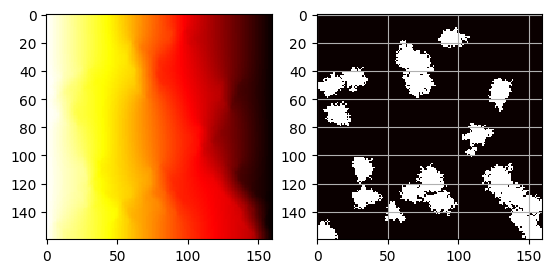

In [63]:
fig, axs=plt.subplots(1,2)
axs[0].imshow(T, cmap='hot', interpolation='nearest')
axs[1].imshow(grid, cmap='hot', interpolation='nearest')
axs[1].grid()
print('paraffin temps', np.sum(T*grid)/np.sum(grid), np.sum(grid))
print('sat eg temps', np.sum(T*(1-grid))/np.sum(1-grid), np.sum(1-grid))
print('paraffin heat diff(left/right)', (np.sum((distF[1,:,:]-distF[3,:,:])*grid))/np.sum(grid))
print('sat eg heat diff(left/right)', np.sum((distF[1,:,:]-distF[3,:,:])*(1-grid))/np.sum(1-grid))
print('paraffin heat flux(left/right)', np.sum((distF[1,:,:]-distF[3,:,:]+distF[0,:,:])*(tauMap-0.5)/tauMap*(grid))/(np.sum(grid)))
print('sat eg heat flux(left/right)', np.sum((distF[1,:,:]-distF[3,:,:])*(tauMap-0.5)/tauMap*(1-grid))/(np.sum(1-grid)))
print('paraffin heat flux all directions', np.sum((distF[1,:,:]-distF[3,:,:]+distF[0,:,:]-distF[2,:,:])*(tauMap-0.5)/tauMap*(grid))/(np.sum(grid)))
print('sat eg heat flux all directions', np.sum((distF[1,:,:]-distF[3,:,:]+distF[0,:,:]-distF[2,:,:])*(tauMap-0.5)/tauMap*(1-grid))/(np.sum(1-grid)))
print('total heat flux all directions', np.sum((distF[1,:,:]-distF[3,:,:]+distF[0,:,:]-distF[2,:,:])*(tauMap-0.5)/tauMap)/160**2)
print('tc all directions', np.sum((distF[1,:,:]-distF[3,:,:]+distF[0,:,:]-distF[2,:,:])*(tauMap-0.5)/tauMap)/160**2*1000/(tHot-tCold))
print('tc right/left', np.sum((distF[1,:,:]-distF[3,:,:])*(tauMap-0.5)/tauMap)/(160**2*(tHot-tCold))*1000)

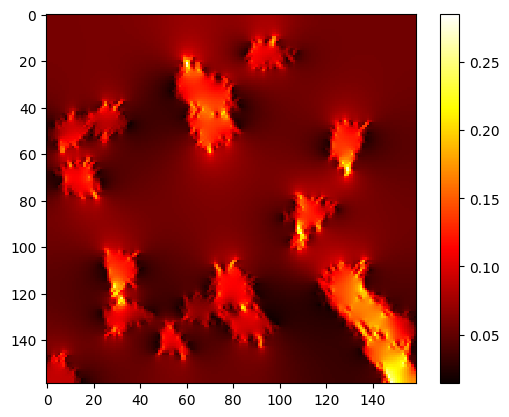

In [64]:
dT=np.sqrt((((T[:,:-1]-T[:,1:])**2)[:-1,:]+((T[:-1,:]-T[1:,:])**2)[:,:-1]))
plt.imshow(dT, cmap='hot', interpolation='nearest')
plt.colorbar()

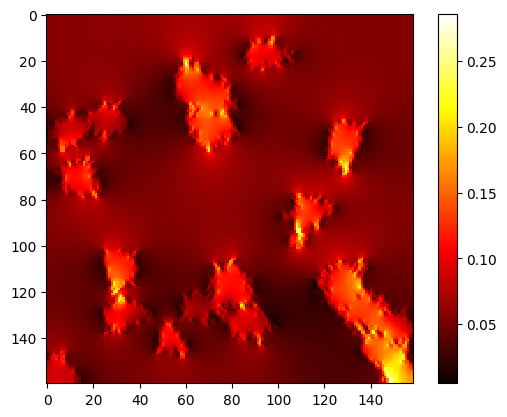

In [65]:
dT=(T[:,:-1]-T[:,1:])
plt.imshow(dT, cmap='hot', interpolation='nearest')
plt.colorbar()

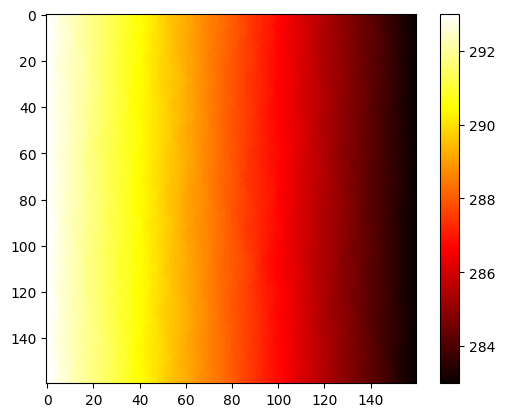

In [ ]:
plt.imshow(T[:,:], cmap='hot', interpolation='nearest')
plt.colorbar()

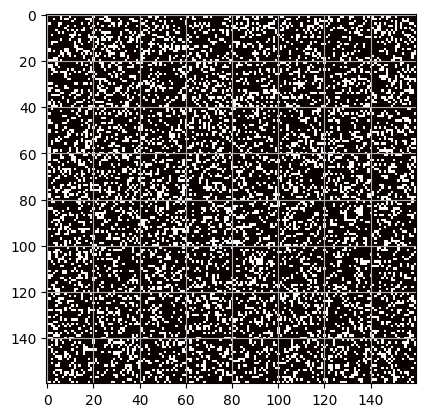

In [357]:
plt.imshow(grid, cmap='hot', interpolation='nearest')
plt.grid()

In [ ]:
static_data=[]

In [66]:
for i in range(2000):
    wt=random.random()*5.5
    sample=generateSample3(160, 160, (random.random()%0.001)+0.0005, 0.05, wt)
    cond, T=lbm(sample)
    static_data.append([sample, T, cond, wt])
    print('iteration', i, cond, wt)

0.10090791256802137 24 25600
CONVERGED ON STEP 45619 WITH ERROR 9.999187374867979e-09
iteration 0 0.4786065602860822 0.4961517249936295
0.6469329799880573 19 25600
CONVERGED ON STEP 25990 WITH ERROR 9.999511207704506e-09
iteration 1 1.4645389841862697 3.3997439594106997
0.5908400992715458 15 25600
CONVERGED ON STEP 27984 WITH ERROR 9.999798780879686e-09
iteration 2 1.3192665938374122 3.083174080669935
0.599732476532531 23 25600
CONVERGED ON STEP 22375 WITH ERROR 9.999755368425624e-09
iteration 3 1.3683260255058554 3.1330630314966688
0.038822748022193765 13 25600
CONVERGED ON STEP 11584 WITH ERROR 9.999818182145217e-09
iteration 4 2.29958275554952 5.259408113779376
0.5481844658749573 19 25600
CONVERGED ON STEP 33386 WITH ERROR 9.999691469344727e-09
iteration 5 1.1931963271861443 2.845398275517546
0.06197059035798058 12 25600
CONVERGED ON STEP 13386 WITH ERROR 9.999756838847378e-09
iteration 6 2.22335946688601 5.1172056368872525
0.0012206342550685756 32 25600
CONVERGED ON STEP 10187 WITH

KeyboardInterrupt: 

In [67]:
len(static_data)

6636

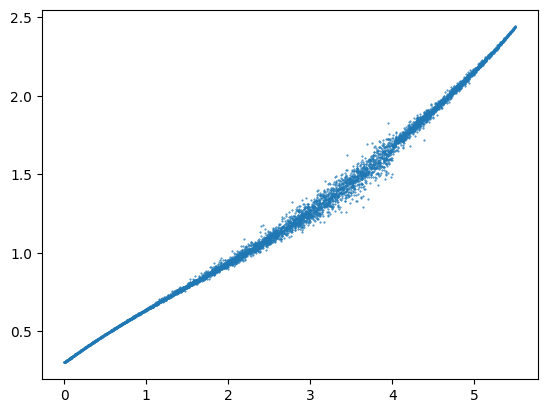

In [70]:
plt.scatter([x[-1] for x in static_data], [x[-2] for x in static_data], s=0.2)
# for x in static_data[::100]:
#     display(tensorToImageTransform(torch.tensor(x[0], dtype=torch.float32)))

In [348]:
print(*[x[-2] for x in static_data], sep=', ')
np.savetxt('graph.csv', np.array([[x[-1], x[-2]] for x in static_data]), delimiter=',')

0.30666839778521193, 0.32476246167328304, 0.34255258655889287, 0.3599698975929304, 0.3770534631290575, 0.39407370373202105, 0.41073801022852124, 0.4276195225037435, 0.4433030140607512, 0.45948653967324926, 0.47542197424948546, 0.4907473933111985, 0.5061484903782202, 0.5213087687194571, 0.5365903863857477, 0.5519933311305588, 0.567373894859503, 0.5812567022182895, 0.5964808903424158, 0.610688082587104, 0.6252162108252894, 0.6397799539181191, 0.654395425799804, 0.6691995451068198, 0.68203571062771, 0.6953786747809871, 0.7108920635228979, 0.7247384853624282, 0.7378932707848619, 0.7520299841977812, 0.7683216714325858, 0.7793162402870769, 0.7943282603354819, 0.8085424608885352, 0.8220941164648135, 0.8382240347022759, 0.8509096310054393, 0.8670645923671232, 0.8801779841854613, 0.8952961858399362, 0.9080026754571452, 0.9225000836701018, 0.9375760503332126, 0.9507178661282493, 0.9653476434226733, 0.9812664350344923, 0.9978796384112122, 1.0117830476748284, 1.0258928064394683, 1.0462716073590703

In [ ]:
data1=[]
for i, in enumerate(np.linspace(0, 5.5, 2000)):
    wt=random.random()*5.5
    sample=generateSample3(160, 160, (random.random()%0.0005)+0.0005, 0.05, wt)
    cond, T=lbm(sample)
    data1.append([sample, T, cond, wt])
    print(i, cond)

0.0 0 25600
0 0.0004852568363577819
10000 2.5356323873589253e-07
20000 1.438917965137291e-07
30000 9.023568288277473e-08
40000 5.6985937917303497e-08
50000 3.6004184771236404e-08
60000 2.2748414640048075e-08
70000 1.4373098137991925e-08
CONVERGED ON STEP 77902 WITH ERROR 9.999634169355103e-09
0 0.18497028520914477
0.0005661976828161093 15 25600
0 0.0004852568363577819
10000 2.537690594071004e-07
20000 1.4394495444811841e-07
30000 9.021959253731131e-08
40000 5.694557497498456e-08
50000 3.596129360608609e-08
60000 2.2711961999002605e-08
70000 1.4345753290362741e-08
CONVERGED ON STEP 77858 WITH ERROR 9.999609100600334e-09
1 0.18566691160056975
0.0011323206694999418 13 25600
0 0.0004852568363577819
10000 2.534855437883851e-07
20000 1.438385915907256e-07
30000 9.016151787254198e-08
40000 5.690886175028349e-08
50000 3.593612868574626e-08
60000 2.2693209213812378e-08
70000 1.4330550798556092e-08
CONVERGED ON STEP 77828 WITH ERROR 9.999814457725579e-09
2 0.18636604070815144
0.00169836897483205

KeyboardInterrupt: 

In [98]:
tauDiffs=[]
lowTau=0.5588
for highTau in np.linspace(lowTau, lowTau+1.5, 20):
    data2=[]
    for i, wt in enumerate(np.linspace(0, 5.5, 7)):
        sample=generateSample3(160, 160, (random.random()%0.0005)+0.0005, 0.05, wt)
        cond, T=lbm(sample, lowTau, highTau)
        data2.append([sample, T, cond, wt])
        print(i, cond)
    tauDiffs.append([data2, lowTau, highTau])

0.0 17 25600
CONVERGED ON STEP 128052 WITH ERROR 9.99981401313328e-10
0 0.18491212284587902
0.18459335973033067 19 25600
CONVERGED ON STEP 128052 WITH ERROR 9.99981401313328e-10
1 0.18491212284587902
0.3614138485310391 19 25600
CONVERGED ON STEP 128052 WITH ERROR 9.99981401313328e-10
2 0.18491212284587902
0.5309422939817553 13 25600
CONVERGED ON STEP 128052 WITH ERROR 9.99981401313328e-10
3 0.18491212284587902
0.6936206664187873 18 25600
CONVERGED ON STEP 128052 WITH ERROR 9.99981401313328e-10
4 0.18491212284587902
0.15014407357145454 19 25600
CONVERGED ON STEP 128052 WITH ERROR 9.99981401313328e-10
5 0.18491212284587902
-2.3424061703636312e-05 26 25600
CONVERGED ON STEP 128052 WITH ERROR 9.99981401313328e-10
6 0.18491212284587902
0.0 21 25600
CONVERGED ON STEP 129588 WITH ERROR 9.999670654204446e-10
0 0.18502969448096254
0.18459335973033067 13 25600
CONVERGED ON STEP 152359 WITH ERROR 9.99993528782463e-10
1 0.21739132620042925
0.3614138485310391 22 25600
CONVERGED ON STEP 104971 WITH 

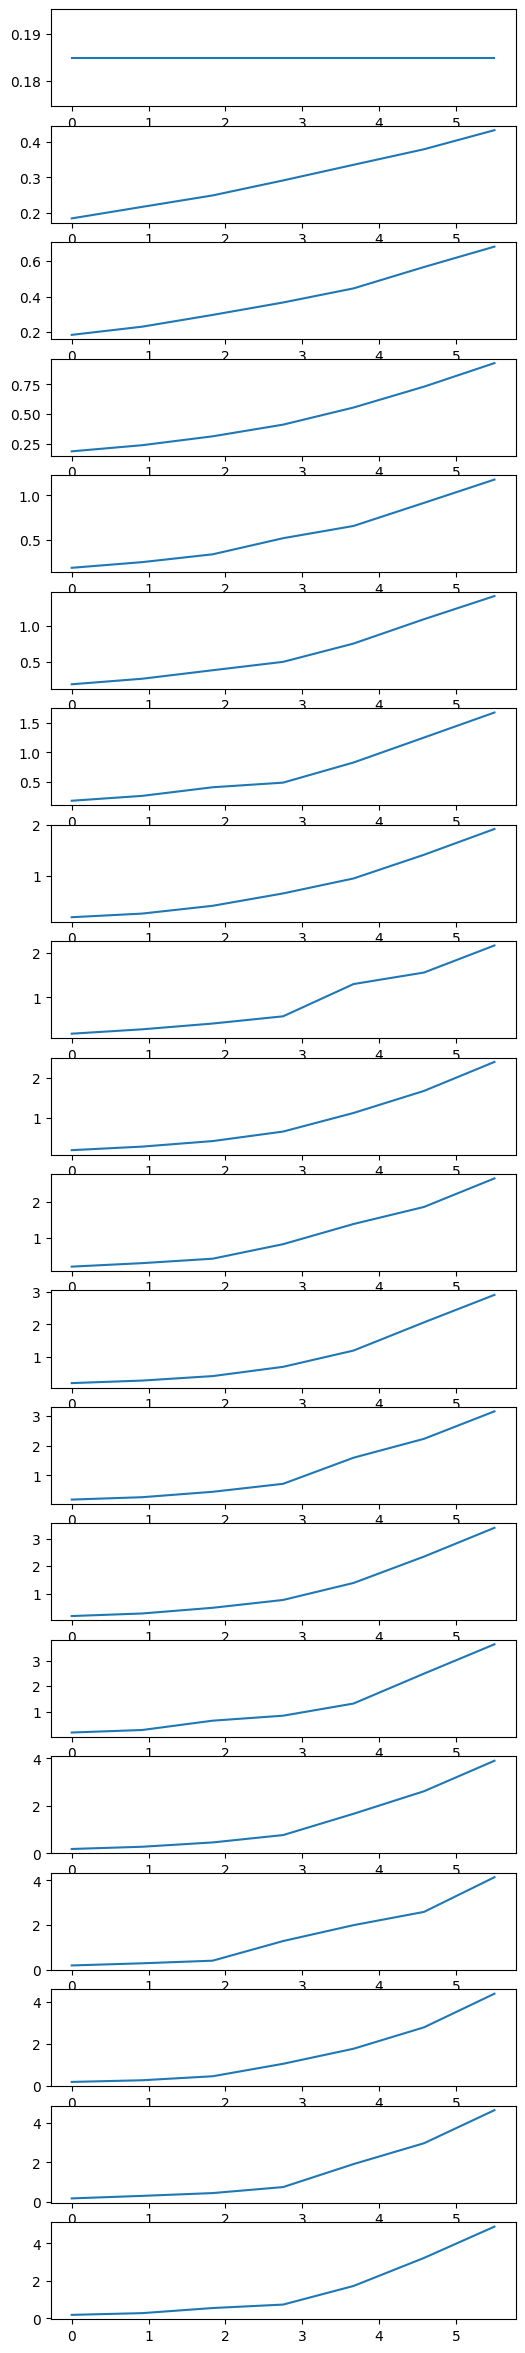

In [105]:
fig=plt.figure(figsize=(6, 30))
for i, d in enumerate(tauDiffs):
    plt.subplot(len(tauDiffs), 1,  i+1)
    plt.plot([x[-1] for x in d[0]], [x[-2] for x in d[0]])

In [51]:
data=[]
for i, wt in enumerate(np.linspace(0, 5.5, 200)):
    sample=generateSample3(160, 160, (random.random()%0.0005)+0.0005, 0.05, wt)
    cond, T=lbm(sample)
    data.append([sample, T, cond, wt])
    print(i, cond)

0.0 24 25600
CONVERGED ON STEP 83816 WITH ERROR 9.999386059760397e-10
0 0.3070229959599195
0.005684192063061593 15 25600
CONVERGED ON STEP 84238 WITH ERROR 9.999831446476036e-10
1 0.3094385657288867
0.011360860268747209 22 25600
CONVERGED ON STEP 87414 WITH ERROR 9.99967314626319e-10
2 0.31223829795732483
0.017030019545560986 16 25600
CONVERGED ON STEP 82251 WITH ERROR 9.999766907803903e-10
3 0.31535053379745154
0.022691684782539214 26 25600
CONVERGED ON STEP 84256 WITH ERROR 9.999622288375783e-10
4 0.3187452220255607
0.02834587082938063 23 25600
CONVERGED ON STEP 84292 WITH ERROR 9.99946054471371e-10
5 0.32059572792567353
0.03399259249657631 20 25600
CONVERGED ON STEP 81631 WITH ERROR 9.99950598126433e-10
6 0.32447991750542876
0.03963186455553896 12 25600
CONVERGED ON STEP 95535 WITH ERROR 9.9998470473646e-10
7 0.32656332480497463
0.04526370173873168 15 25600
CONVERGED ON STEP 122887 WITH ERROR 9.9999769068826e-10
8 0.33118006463874894
0.05088811873979632 17 25600
CONVERGED ON STEP 78

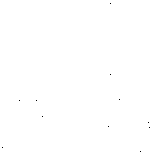

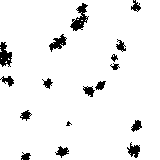

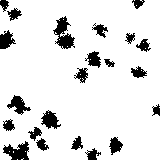

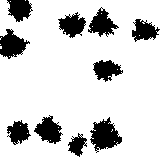

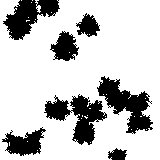

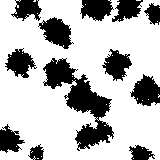

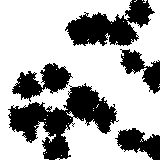

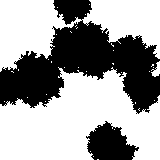

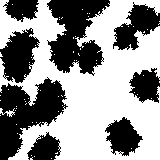

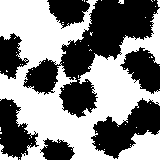

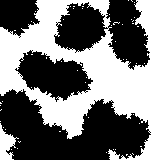

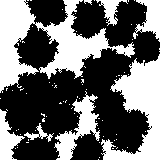

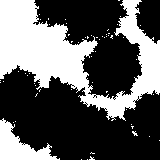

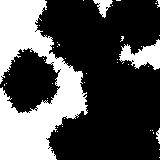

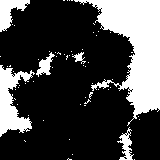

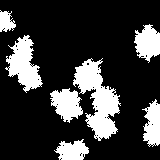

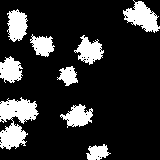

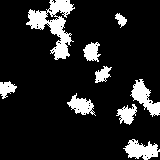

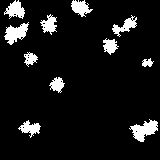

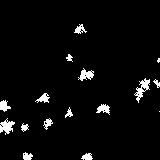

In [70]:
for i, (orig, temps, cond, wt) in enumerate(data1):
    if i%10==0:
        display(tensorToImageTransform(torch.tensor(orig, dtype=torch.float32)))

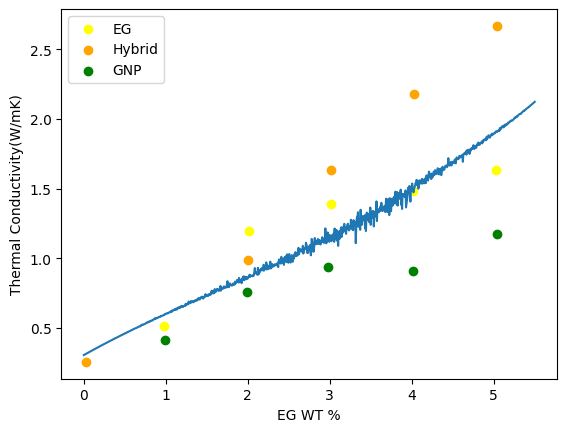

In [386]:
sPVol=[np.sum(x[0])/160**2 for x in data1]
experimentEG=[0.9808358718952985, 0.5177376980481276, 2.0206308527956423, 1.195872217655497, 3.017552342730042, 1.3927034476089164, 4.012604161629838, 1.4813274664345695, 5.026094805215738, 1.6370984639685382]
hybrid=[0.026014215947004038, 0.25743436004061665, 2.0083812839482293, 0.9869284206115113, 3.0130393436809957, 1.6315136276453428, 4.024595844817305, 2.1753461309092086, 5.043888915751978, 2.666932611253486]
gnp=[0.9877343132988412, 0.41698499427816166, 1.9957448866108987, 0.7555969247135054, 2.9838337926921654, 0.9412423641667874, 4.011379204745097, 0.9104330867301706, 5.035443160388763, 1.1781345196073696]
# plt.plot([x[-1] for x in data1[:-15]], [x[-2] for x in data1[:-15]])
plt.plot([x[-1] for x in static_data], [x[-2] for x in static_data])
plt.scatter(experimentEG[::2], experimentEG[1::2], label='EG', color='yellow')
plt.scatter(hybrid[::2], hybrid[1::2], label='Hybrid', color='orange')
plt.scatter(gnp[::2], gnp[1::2], label='GNP', color='green')
plt.plot()
plt.xlabel('EG WT %')
plt.ylabel('Thermal Conductivity(W/mK)')
plt.legend()

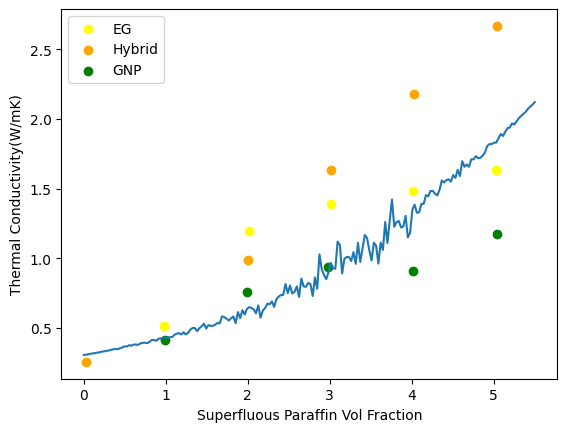

In [387]:
sPVol=[np.sum(x[0])/160**2 for x in data]
plt.plot([x[-1] for x in data], [x[-2] for x in data])
plt.scatter(experimentEG[::2], experimentEG[1::2], label='EG', color='yellow')
plt.scatter(hybrid[::2], hybrid[1::2], label='Hybrid', color='orange')
plt.scatter(gnp[::2], gnp[1::2], label='GNP', color='green')
plt.xlabel('Superfluous Paraffin Vol Fraction')
plt.ylabel('Thermal Conductivity(W/mK)')
plt.legend()

Text(0, 0.5, 'Thermal Conductivity(W/mK)')

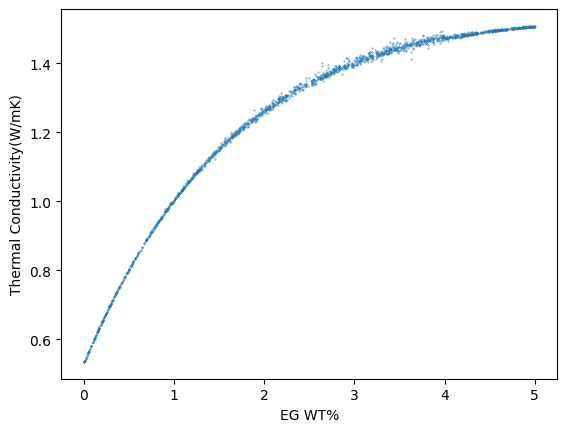

In [ ]:
wts=[data[i][-1] for i in range(len(data))]
conds=[data[i][-2] for i in range(len(data))]
plt.scatter(wts, conds, s=0.1)
plt.xlabel('EG WT%')
plt.ylabel('Thermal Conductivity(W/mK)')

In [ ]:
sfVolPts=[np.array(data[i][0]).sum()/(160*160) for i in range(len(data))]

Text(0, 0.5, 'Thermal Conductivity(W/mK)')

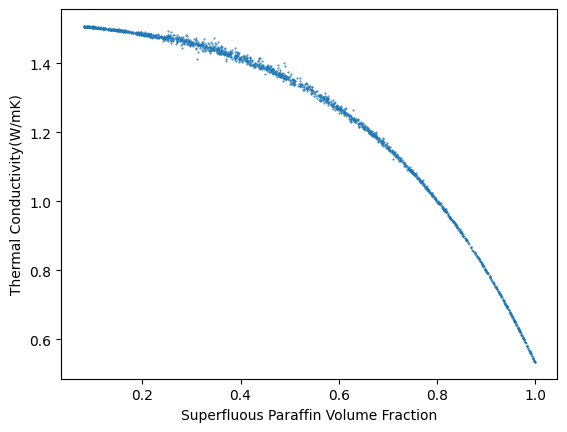

In [ ]:
plt.scatter(sfVolPts, conds, s=0.2)
plt.xlabel('Superfluous Paraffin Volume Fraction')
plt.ylabel('Thermal Conductivity(W/mK)')

In [71]:
np.savetxt('updated_lbm_data.csv', np.array([[x[-1], x[-2]] for x in static_data]), delimiter=',')

In [72]:
from PIL import Image
for i, datapoint in enumerate(static_data):
    sample=Image.fromarray(np.array(datapoint[0]).astype('uint8')*255).convert('RGB')
    sample.save('./data/updated_lbm_data/'+str(i)+'.jpeg')
    # temp=Image.fromarray(255*(datapoint[1]-np.min(datapoint[1]))/(np.max(datapoint[1])-np.min(datapoint[1]))).convert('RGB')
    # temp.save('./data/temperatures2/'+str(i)+'.jpeg')

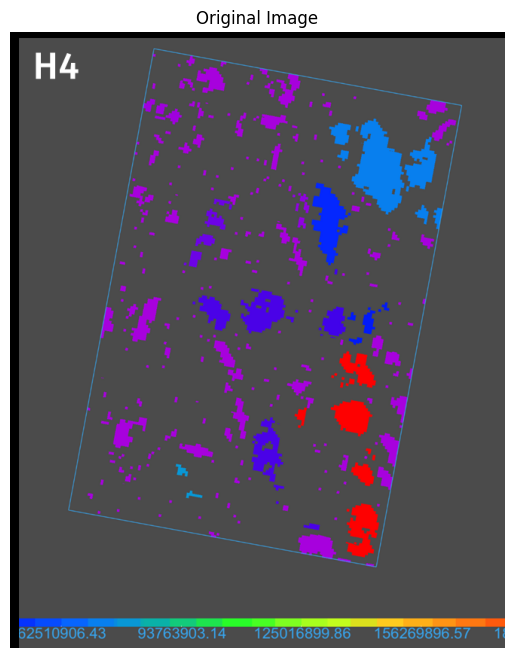

In [28]:
import cv2

# Load the image
image_path = "./hybrid4.png"
image = cv2.imread(image_path)

# Convert to RGB for displaying purposes
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the original image to visualize
plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title("Original Image")
plt.axis("off")
plt.show()

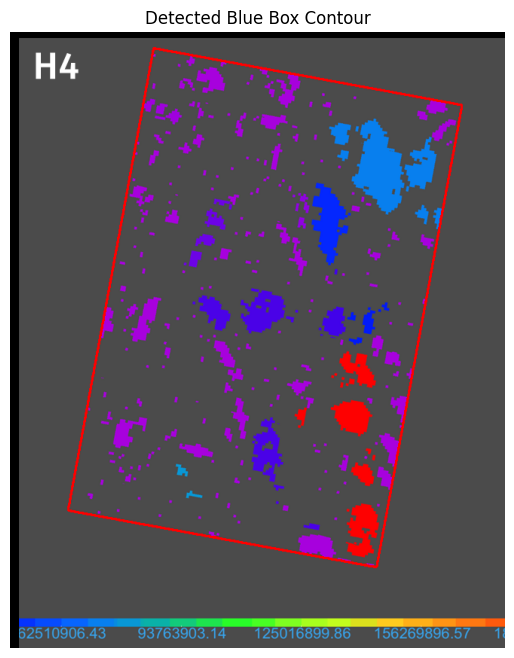

True

In [29]:
# Convert the image to HSV color space for better color segmentation
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# Define the color range for detecting the blue box
blue_lower = np.array([90, 50, 50])  # Lower bound of blue in HSV
blue_upper = np.array([130, 255, 255])  # Upper bound of blue in HSV

# Create a mask for the blue color
blue_mask = cv2.inRange(hsv_image, blue_lower, blue_upper)

# Find contours from the mask
contours, _ = cv2.findContours(blue_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area and assume the largest is the blue box
contours = sorted(contours, key=cv2.contourArea, reverse=True)
blue_box_contour = contours[0] if contours else None

# Draw the detected contour on a copy of the original image for visualization
contour_image = image_rgb.copy()
if blue_box_contour is not None:
    cv2.drawContours(contour_image, [blue_box_contour], -1, (255, 0, 0), 2)

# Display the image with the detected contour
plt.figure(figsize=(10, 8))
plt.imshow(contour_image)
plt.title("Detected Blue Box Contour")
plt.axis("off")
plt.show()

# Check if contour was detected
blue_box_contour is not None

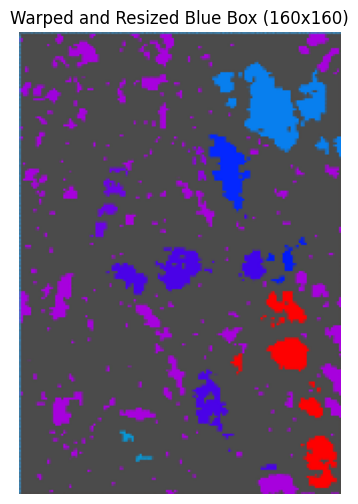

In [31]:
epsilon = 0.02 * cv2.arcLength(blue_box_contour, True)
approx_corners = cv2.approxPolyDP(blue_box_contour, epsilon, True)

# Ensure we have 4 points (a quadrilateral)
if len(approx_corners) == 4:
    # Sort the corners to identify top-left, top-right, bottom-left, bottom-right
    approx_corners = approx_corners[:, 0, :]  # Remove unnecessary dimensions
    rect = np.zeros((4, 2), dtype="float32")

    # Sum and diff to identify corners (top-left, bottom-right, etc.)
    s = approx_corners.sum(axis=1)
    diff = np.diff(approx_corners, axis=1)

    rect[0] = approx_corners[np.argmin(s)]  # Top-left
    rect[2] = approx_corners[np.argmax(s)]  # Bottom-right
    rect[1] = approx_corners[np.argmin(diff)]  # Top-right
    rect[3] = approx_corners[np.argmax(diff)]  # Bottom-left

    # Define the destination points for perspective transform (160x160 output)
    dest = np.array([[0, 0], [160, 0], [160, 230], [0, 230]], dtype="float32")

    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dest)

    # Warp the perspective to flatten the blue box
    warped = cv2.warpPerspective(image, M, (160, 230))

    # Convert to RGB for visualization
    warped_rgb = cv2.cvtColor(warped, cv2.COLOR_BGR2RGB)

    # Display the result
    plt.figure(figsize=(6, 6))
    plt.imshow(warped_rgb)
    plt.title("Warped and Resized Blue Box (160x160)")
    plt.axis("off")
    plt.show()
else:
    print("Failed to detect four corners of the blue box.")

In [32]:
tensorToImageTransform(warped_rgb)
warped_rgb=torch.tensor(warped_rgb, dtype=torch.float32)
torch.abs(warped_rgb[:,:,0]-warped_rgb[:,:,1]).shape

torch.Size([230, 160])

In [33]:
threshold = 20  # You can adjust this depending on how strict you want the gray detection

# Check if the pixel is gray (R, G, B are close to each other)
gray_mask = torch.abs(warped_rgb[:,:,0] - warped_rgb[:,:,1]) < threshold
gray_mask &= torch.abs(warped_rgb[:,:,1] - warped_rgb[:,:,2]) < threshold

# Set non-gray pixels to black (0,0,0)
warped_rgb[~gray_mask, :] = 0

# Set gray pixels to white (255, 255, 255)
warped_rgb[gray_mask, :] = 1
# tensorToImageTransform(warped_rgb)

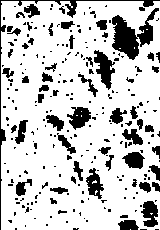

In [34]:
warped_rgb=warped_rgb[:,:,0]
tensorToImageTransform(warped_rgb[:,:])

In [ ]:
torch.sum(1-warped_rgb)/(warped_rgb.shape[0]*warped_rgb.shape[1])
grid=[[0 for i in range(160)] for j in range(160)]
grid=generateSample3(160, 160, (random.random()%0.0005)+0.6555, 0.05, 3.99)

In [52]:
cond, T=lbm(warped_rgb[:,:], 0.52, 100)
# cond, T=lbm(grid, 0.5975, 1.175)
# cond, T=lbm(grid, 0.536821, 0.7988)

0 0.0004852568363577819
10000 2.525365364479693e-07
20000 1.4826346242902795e-07
30000 1.0447063170864668e-07
40000 7.812556362124081e-08
50000 5.981801459775905e-08
60000 4.6357465700438995e-08
70000 3.6244997997286924e-08
80000 2.8578564484489853e-08
90000 2.273871716016225e-08
100000 1.827447105559261e-08
110000 1.4849129262147361e-08
120000 1.2208573472001566e-08
130000 1.0160270485336278e-08
CONVERGED ON STEP 130899 WITH ERROR 9.999846101001541e-09


In [53]:
cond

np.float64(2.9595606357624393)

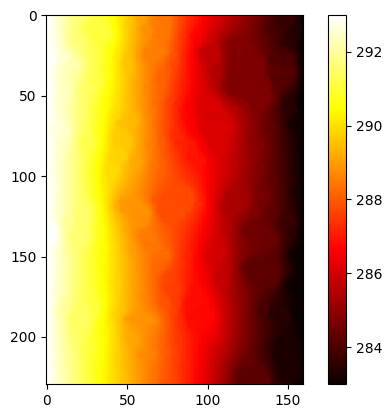

In [54]:
plt.imshow(T[:,:], cmap='hot', interpolation='nearest')
plt.colorbar()

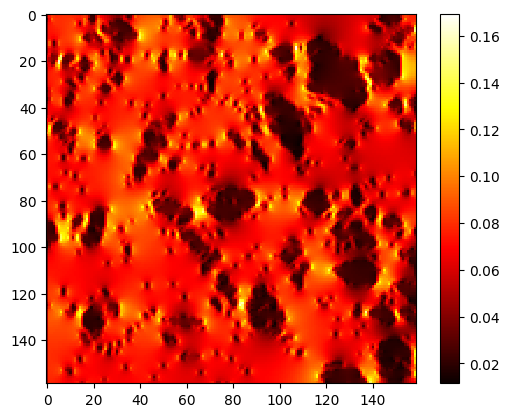

In [281]:
dT=np.sqrt((((T[:,:-1]-T[:,1:])**2)[:-1,:]+((T[:-1,:]-T[1:,:])**2)[:,:-1]))
plt.imshow(dT, cmap='hot', interpolation='nearest')
plt.colorbar()